In [1]:
# Chạy 1 lần 
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install torchvision
# !pip install matplotlib
# !pip install torch
# !pip install einops

In [2]:
# !pip install einops

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

from Model.MICN.layers.Embed import DataEmbedding
from Model.MICN.layers.Autoformer_EncDec import series_decomp, series_decomp_multi

ModuleNotFoundError: No module named 'Model'

In [ ]:
# Giả sử các lớp DataEmbedding, series_decomp, và series_decomp_multi đã được định nghĩa trong layers.Embed và layers.Autoformer_EncDec.


class MIC(nn.Module):
    """
    Mô hình MIC đơn giản với một lớp Linear.
    """
    def __init__(self, configs):
        super(MIC, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.d_model)

    def forward(self, x):
        return self.layer(x)


In [ ]:

class SeasonalPrediction(nn.Module):
    """
    Khối dự báo mùa vụ với một lớp Linear.
    """
    def __init__(self, configs):
        super(SeasonalPrediction, self).__init__()
        self.layer = nn.Linear(configs.d_model, configs.pred_len)

    def forward(self, x):
        return self.layer(x)


In [ ]:

class Model(nn.Module):
    """
    Mô hình chính bao gồm các khối embedding, encoder và decoder.
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq, configs.dropout)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=configs.d_model, nhead=configs.n_heads, dropout=configs.dropout),
            num_layers=configs.d_layers)
        self.decoder = nn.Linear(configs.d_model, 1)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        enc_out = self.embedding(x_enc, x_mark_enc)
        enc_out = self.encoder(enc_out)
        dec_out = self.decoder(enc_out[:, -1, :])
        return dec_out.squeeze(-1)


In [ ]:
def evaluate_forecast(true_values, predicted_values):
    """
    Hàm tính toán các chỉ số đánh giá cho dự báo.
    """
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    mae = np.mean(np.abs(true_values - predicted_values))
    return rmse, mape, mae

In [ ]:


def export_forecast_by_datasets(datasets, index_col, attribute, train_ratios, prediction_lengths):
    """
    Hàm xuất dự báo cho các tập dữ liệu khác nhau.
    """
    for dataset in datasets:
        # Load và tiền xử lý dữ liệu
        data = pd.read_csv(dataset, index_col=index_col)
        data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
        # data.index = pd.to_datetime(data.index, format='%Y-%m-%d') này của TT
        # data.index = pd.to_datetime(data.index, format='%m/%d/%Y') nay cua KDM
        data.info()
        # data[attribute] = data[attribute].str.replace(',', '').astype(float) nay cua KDM
        data.dropna(inplace=True)

        for train_ratio in train_ratios:
            # Chia dữ liệu thành tập train và test
            target = data[attribute].values
            train_size = int(len(target) * train_ratio)

            # Chuẩn hóa dữ liệu
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = scaler.fit_transform(target.reshape(-1, 1))
            train_data = scaled_data[0:train_size, :]

            # Chuẩn bị dữ liệu train
            x_train = []
            y_train = []
            for i in range(1, len(train_data)):
                x_train.append(train_data[i-1:i, 0])
                y_train.append(train_data[i, 0])
            x_train = np.array(x_train)
            y_train = np.array(y_train)
            x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
            x_train = x_train.unsqueeze(2)

            # Chuẩn bị dữ liệu test
            test_data = scaled_data[train_size-1:, :]
            x_test = []
            y_test = target[train_size:]
            for i in range(1, len(test_data)):
                x_test.append(test_data[i-1:i, 0])
            x_test = np.array(x_test)
            x_test = torch.tensor(x_test, dtype=torch.float32)
            x_test = x_test.unsqueeze(2)

            # Định nghĩa các cấu hình của mô hình
            configs = type('', (), {})()
            configs.task_name = 'long_term_forecast'
            configs.enc_in = 1
            configs.d_model = 128
            configs.embed = 'timeF'
            configs.freq = 'D'
            configs.dropout = 0.05
            configs.n_heads = 8
            configs.d_layers = 3

            # Khởi tạo mô hình và chuyển nó sang thiết bị phù hợp
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = Model(configs)
            model.to(device)

            # Train model
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            for epoch in range(100):
                optimizer.zero_grad()
                output = model(x_train.to(device), None, x_test.to(device), None)
                loss = criterion(output, y_train.to(device))
                loss.backward()
                optimizer.step()

            # Chuyển mô hình sang chế độ đánh giá
            model.eval()

            plt.figure(dpi=120)
            plt.xlabel(index_col)
            plt.ylabel(attribute)
            plt.plot(data.index[:train_size], target[:train_size], label='Training Data')
            plt.plot(data.index[train_size:], target[train_size:], label='Actual Data')

            last_date = data.index[-1]

             # Tạo và vẽ dự báo cho các độ dài khác nhau
            for pred_len in prediction_lengths:
                configs.pred_len = pred_len

                with torch.no_grad():
                    predictions = model(x_test.to(device), None, torch.zeros(1, pred_len, 1, dtype=torch.float32).to(device), None)
                    predictions = scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1))

                forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=pred_len)
                plt.plot(forecast_dates, predictions[-pred_len:], label=f'Next {pred_len} Days Forecast')

                 # Tính toán và in các chỉ số đánh giá hiệu suất
                rmse, mape, mae = evaluate_forecast(y_test[:pred_len], predictions[-pred_len:].flatten())
                print(f'Dataset: {dataset}, Train Ratio: {train_ratio}, Prediction Length: {pred_len}')
                print(f'RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, MAE: {mae:.4f}\n')

            plt.legend(loc='upper left')
            plt.title(f'MICN - {dataset.split(".")[0]} cpyto price (Ratio {int(train_ratio*10)}:{int((10 - train_ratio*10))})')

            plt.show()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.7, Prediction Length: 30
RMSE: 4996.4106, MAPE: 14.39%, MAE: 4692.9924

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.7, Prediction Length: 60
RMSE: 3801.4302, MAPE: 9.83%, MAE: 3291.2073

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 3092.0230, MAPE: 7.58%, MAE: 2600.6103



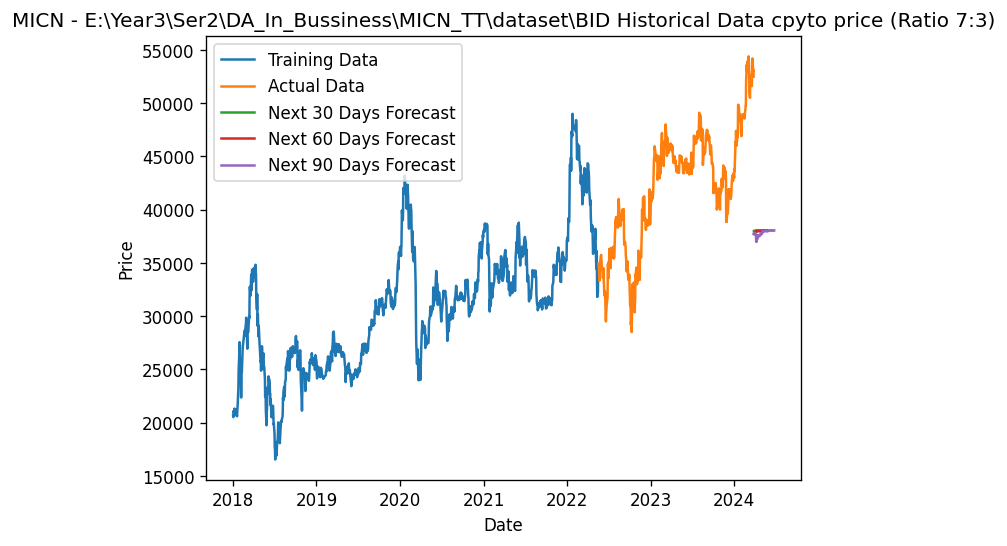

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.8, Prediction Length: 30
RMSE: 2529.5077, MAPE: 4.63%, MAE: 2027.6945

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.8, Prediction Length: 60
RMSE: 4279.8774, MAPE: 8.96%, MAE: 4021.3512

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 5667.0230, MAPE: 11.84%, MAE: 5301.2960



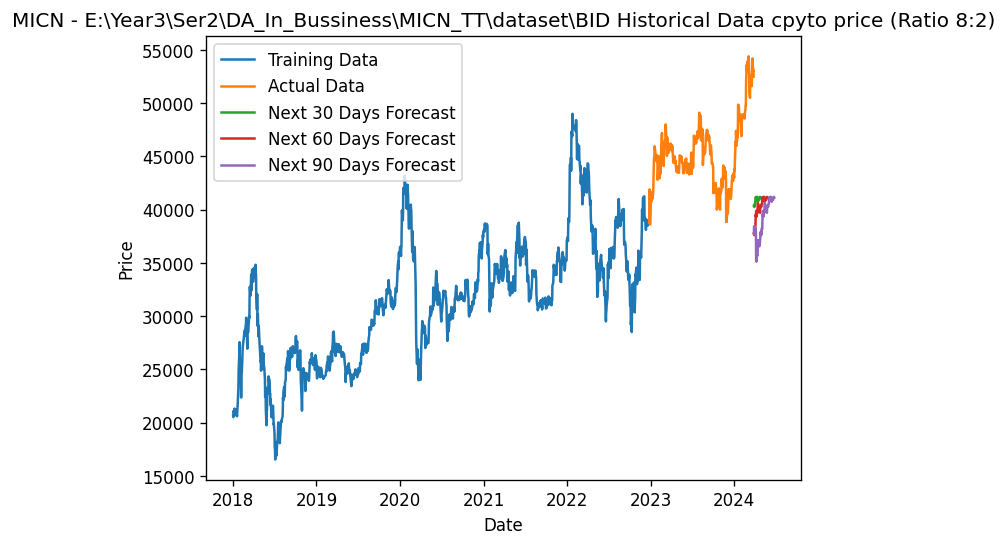

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.9, Prediction Length: 30
RMSE: 3863.0876, MAPE: 8.00%, MAE: 3722.4966

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.9, Prediction Length: 60
RMSE: 4373.3763, MAPE: 7.99%, MAE: 3623.6183

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\BID Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 5738.6340, MAPE: 9.42%, MAE: 4242.4875



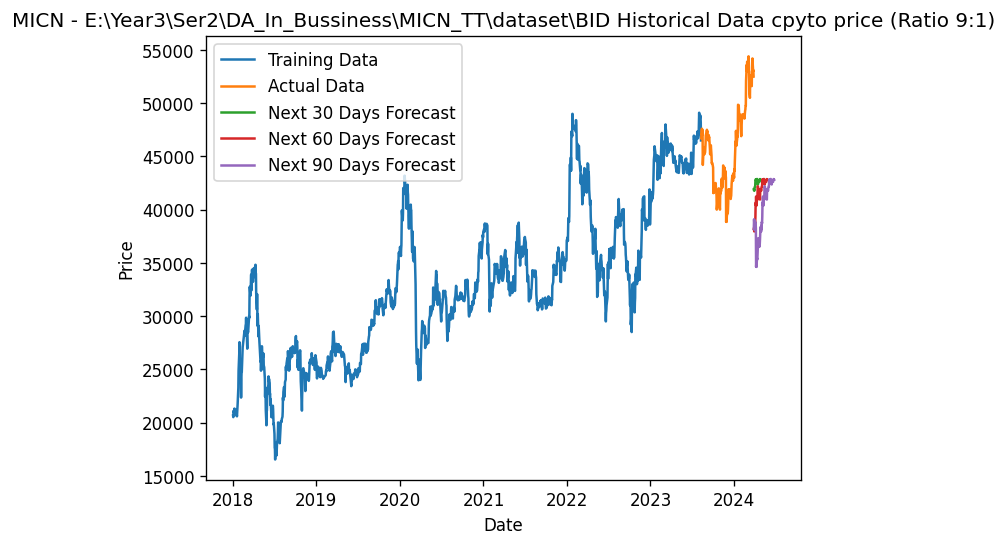

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 30
RMSE: 1559.4440, MAPE: 5.73%, MAE: 1181.1601

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 60
RMSE: 2814.5588, MAPE: 9.44%, MAE: 2082.7649

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 3946.3250, MAPE: 14.29%, MAE: 3122.9973



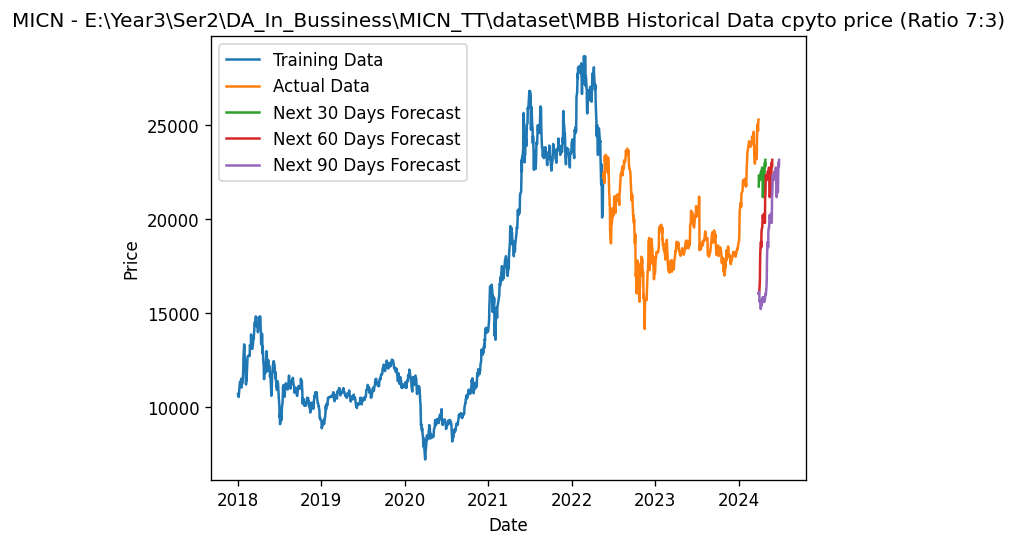

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 30
RMSE: 4207.8725, MAPE: 22.57%, MAE: 4111.5862

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 60
RMSE: 3624.3021, MAPE: 17.48%, MAE: 3118.4014

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 3058.0424, MAPE: 15.32%, MAE: 2786.9764



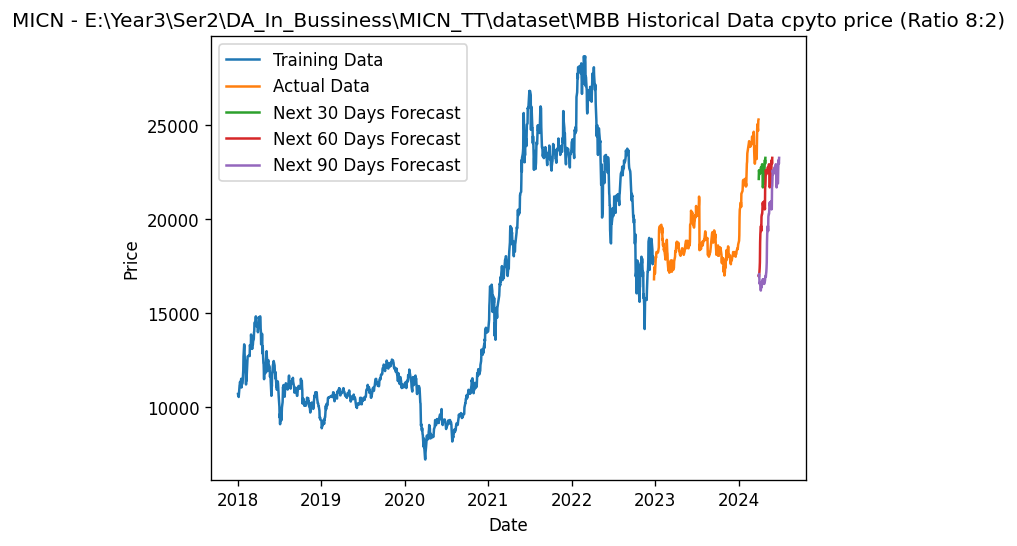

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 30
RMSE: 4406.6649, MAPE: 23.35%, MAE: 4361.9026

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 60
RMSE: 4021.4003, MAPE: 20.24%, MAE: 3672.0621

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\MBB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 3509.4148, MAPE: 16.39%, MAE: 2958.0237



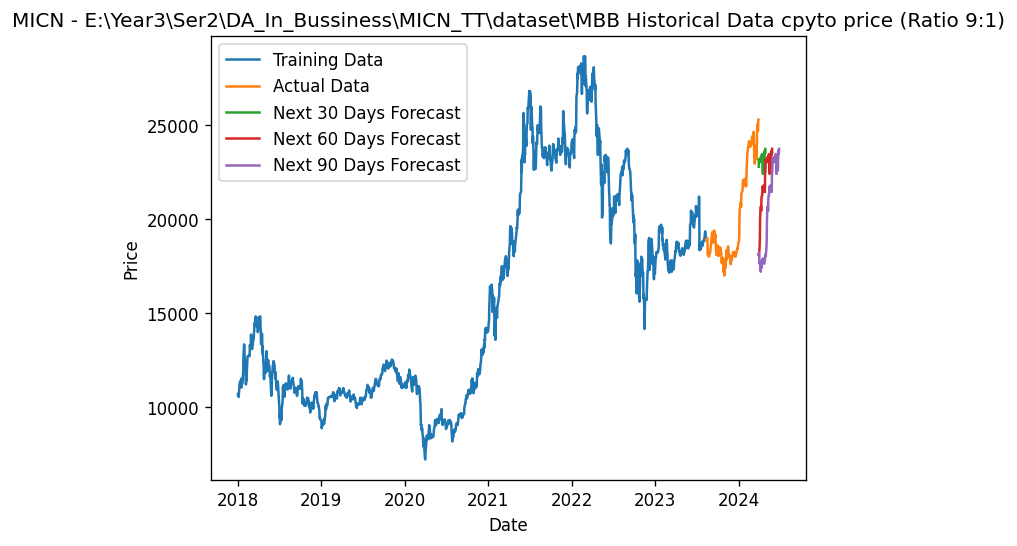

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1555 entries, 2018-01-02 to 2024-03-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     1555 non-null   object
 1   Open      1555 non-null   object
 2   High      1555 non-null   object
 3   Low       1555 non-null   object
 4   Vol.      1555 non-null   object
 5   Change %  1555 non-null   object
dtypes: object(6)
memory usage: 85.0+ KB


e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 30
RMSE: 2018.3895, MAPE: 2.30%, MAE: 1755.9956

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 60
RMSE: 3480.5550, MAPE: 3.75%, MAE: 2797.6772

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 3156.0604, MAPE: 3.26%, MAE: 2516.4864



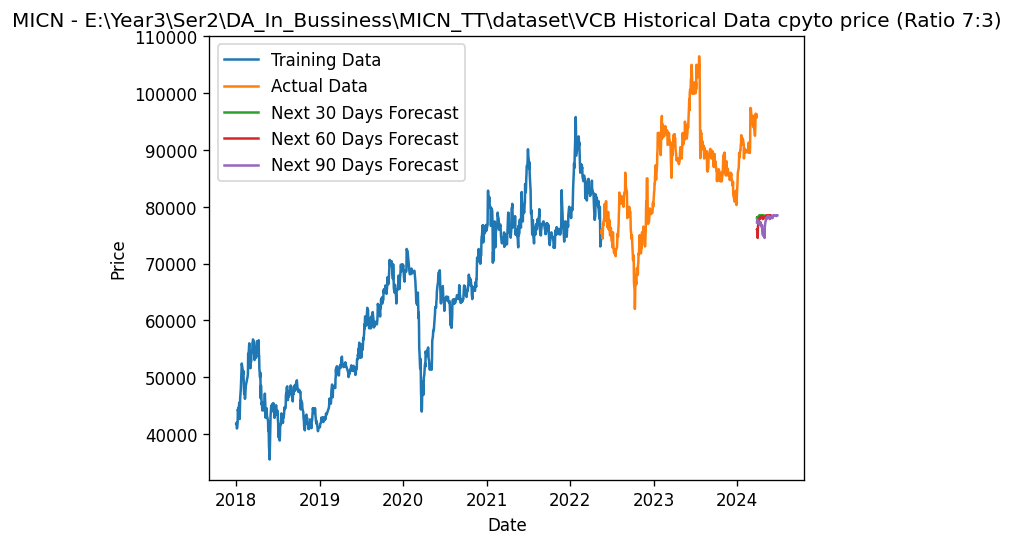

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 30
RMSE: 11677.3355, MAPE: 11.71%, MAE: 10533.5026

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 60
RMSE: 13288.3766, MAPE: 13.97%, MAE: 12693.6573

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 13700.2703, MAPE: 14.47%, MAE: 13134.8321



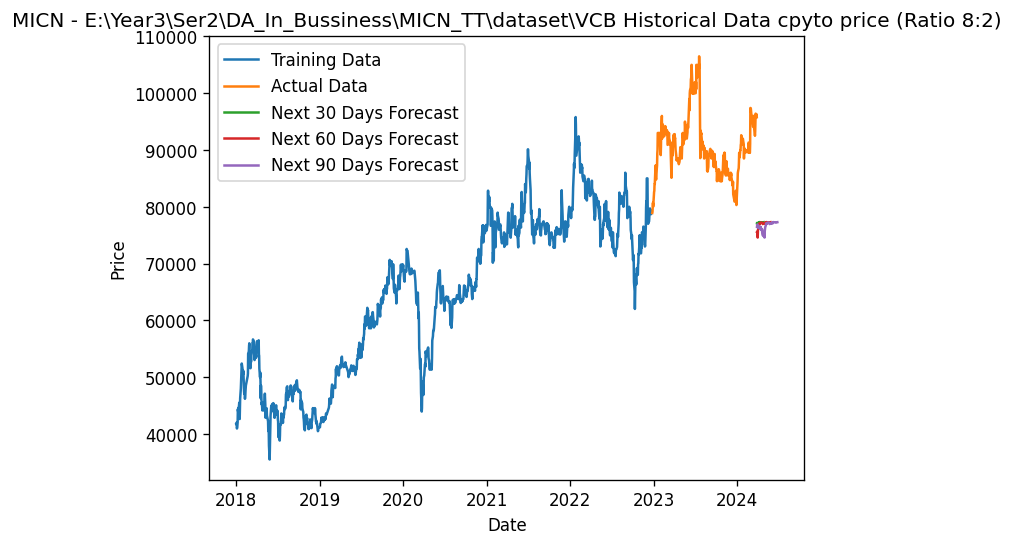

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 30
RMSE: 6648.8333, MAPE: 6.96%, MAE: 6192.6911

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 60
RMSE: 8032.9171, MAPE: 7.83%, MAE: 6917.7271

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\VCB Historical Data.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 9311.3069, MAPE: 9.13%, MAE: 8016.7034



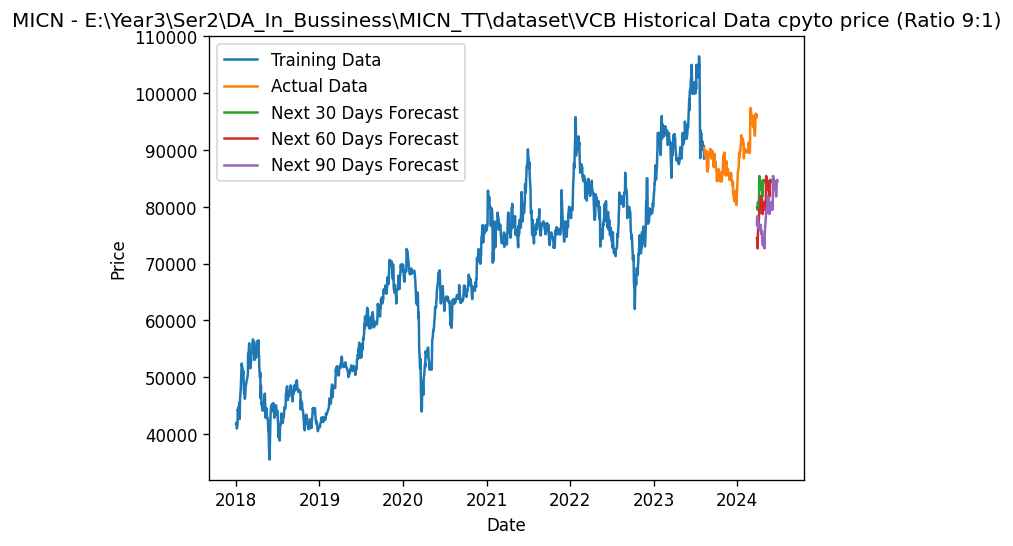

In [ ]:
#Thực thi model 
datasets = ['E:\Year3\Ser2\DA_In_Bussiness\Project_Code\IS403_O21_16\Model\MICN\dataset\BID Historical Data.csv']
index_col = 'Date'
attribute = 'Price'
train_ratios = [0.7, 0.8, 0.9]
prediction_lengths = [30, 60, 90]

export_forecast_by_datasets(datasets, index_col, attribute, train_ratios, prediction_lengths)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1919 entries, 2019-03-01 to 2024-05-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1919 non-null   float64
 1   High       1919 non-null   float64
 2   Low        1919 non-null   float64
 3   Close      1919 non-null   float64
 4   Adj Close  1919 non-null   float64
 5   Volume     1919 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 104.9 KB


e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.7, Prediction Length: 30
RMSE: 1969.1759, MAPE: 155.01%, MAE: 1938.7835

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.7, Prediction Length: 60
RMSE: 1974.3898, MAPE: 157.67%, MAE: 1959.7473

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.7, Prediction Length: 90
RMSE: 1992.3874, MAPE: 151.74%, MAE: 1975.2878



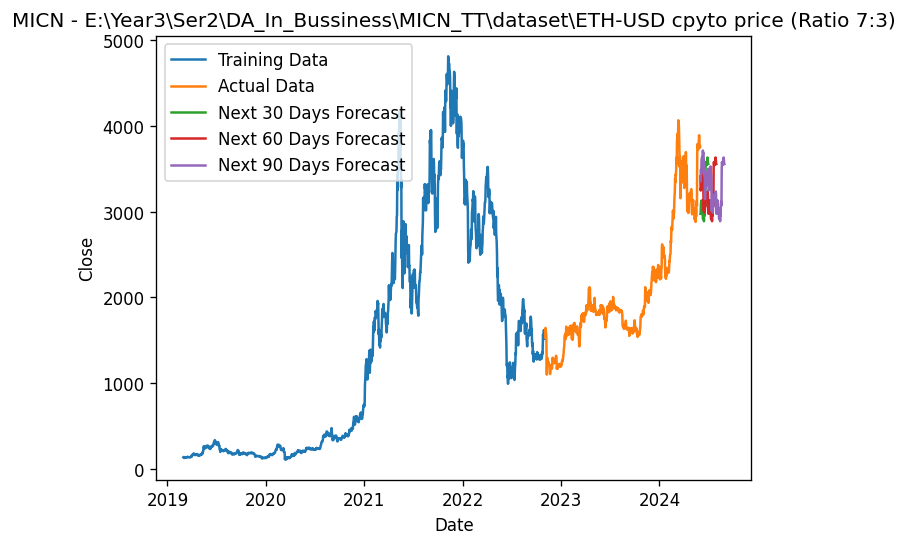

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.8, Prediction Length: 30
RMSE: 1057.8382, MAPE: 54.53%, MAE: 998.1964

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.8, Prediction Length: 60
RMSE: 1005.8717, MAPE: 52.88%, MAE: 971.0321

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.8, Prediction Length: 90
RMSE: 1118.6469, MAPE: 58.25%, MAE: 1070.9455



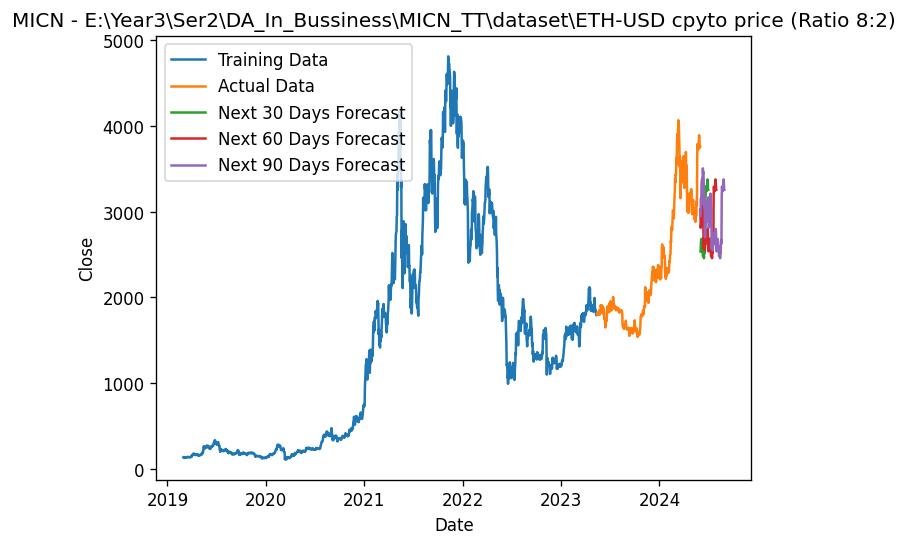

e:\Year3\Ser2\DA_In_Bussiness\MICN_TT\myenv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.9, Prediction Length: 30
RMSE: 760.1239, MAPE: 32.17%, MAE: 701.2630

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.9, Prediction Length: 60
RMSE: 645.1669, MAPE: 26.59%, MAE: 598.8484

Dataset: E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv, Train Ratio: 0.9, Prediction Length: 90
RMSE: 712.7992, MAPE: 28.13%, MAE: 638.6346



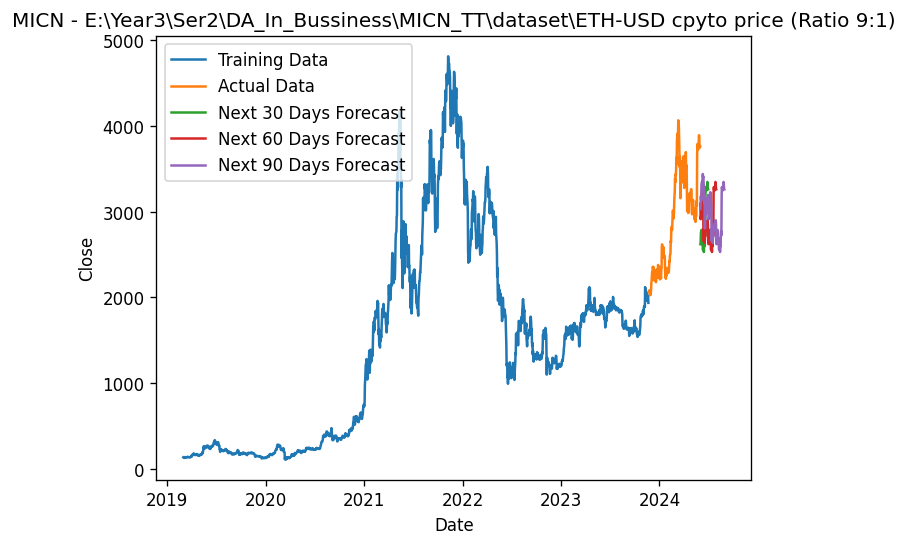

In [ ]:
datasets = ['E:\Year3\Ser2\DA_In_Bussiness\MICN_TT\dataset\ETH-USD.csv']
index_col = 'Date'
attribute = 'Close'
train_ratios = [0.7, 0.8, 0.9]
prediction_lengths = [30, 60, 90]

export_forecast_by_datasets(datasets, index_col, attribute, train_ratios, prediction_lengths)